In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd    # for easier csv parsing
from skimage import io, transform   # for image io and transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
# Dataset we are going to deal with is of facial pose. Over all, 68 different landmark points are annotated for each face.
# read the csv
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')

In [3]:
landmarks_frame

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516
5,137341995_e7c48e9a75.jpg,-4,129,1,178,10,231,30,276,59,...,204,238,260,241,210,281,188,286,166,286
6,1383023626_8a49e4879a.jpg,0,48,-6,94,-10,141,-8,186,6,...,165,233,194,230,163,263,145,268,128,265
7,144044282_87cf3ff76e.jpg,122,104,121,116,121,129,122,142,125,...,165,154,178,154,164,153,159,154,154,153
8,152601997_ec6429a43c.jpg,109,66,108,98,111,132,118,169,127,...,205,216,239,220,208,216,197,217,187,216
9,1549040388_b99e9fa295.jpg,149,89,139,123,136,159,139,195,146,...,231,238,292,243,232,251,212,248,196,242


In [4]:
# get the annotations in an (N, 2) array where N is the number of landmarks.

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name : {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name : person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


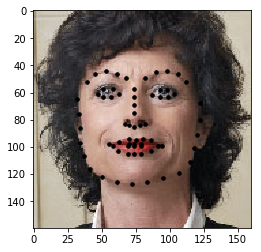

In [5]:
# helper function to show an image and its landmarks and use it to show a sample

def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=50, marker='.', c='k')
    plt.pause(0.001)   # pause a bit so that the plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)), landmarks)
plt.show()

In [6]:
# Dataset Class
# torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:
    # __len__: so that len(dataset) returns the size of dataset
    # __getitem__: to support the indexing such that such that dataset[i] can be used to get ith sample

"""Let’s create a dataset class for our face landmarks dataset. We will read the csv in __init__ but leave the reading of images to __getitem__.
    This is memory efficient because all the images are not stored in the memory at once but read as required."""

"""Sample of our dataset will be a dict {'image': image, 'landmarks': landmarks}. Our dataset will take an optional argument transform
    so that any required processing can be applied on the sample. We will see the usefulness of transform in the next section."""

class FaceLandmarksDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
        return sample

0 (324, 215, 3) (68, 2)


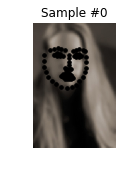

1 (500, 333, 3) (68, 2)


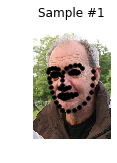

2 (250, 258, 3) (68, 2)


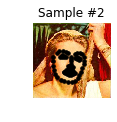

3 (434, 290, 3) (68, 2)


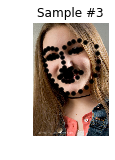

In [7]:
# Initiate this class and iterate through the data samples. We will print sizes of first 4 samples and show their landmarks.

face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv', root_dir='faces/')


fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    print(i, sample['image'].shape, sample['landmarks'].shape)
    
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)
    
    if i == 3:
        plt.show()
        break

In [8]:
# Transforms
# one issue is that the samples are not of the same size. Most neural networks expect the images of a fixed size. Therefore, we will need to write some preprocessing code.
# let's create three transforms:
    # Rescale: to scale the image
    # RandomCrop: to crop from image randomly.This is data augmentation.
    # toTensor: to convert numpy images to torch images(we need to swap axes).
# we will write them as callable classes instead of simple functions so that parameters of the transform need not to be passed everytime it is called.
# For this, we just need to implement __call__ method and if required, __init__ method. We can the use a transform like this:
    # tsfm = Transform(params)
    # transformed_sample = tsfm(sample)   

In [9]:
# Rescale the image in a sample to a given size.

class Rescale(object):
    """
    Args:
         output_size (tuple or int): Desired output size. If tuple, output is
         matched to output_size. If int, smaller of image edges is matched
         to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size*h/w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size*w/h
        else:
            new_h, new_w = self.output.size
            
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        
        # h and w are swapped for landmarks because for images, x and y axes are axes 1 and 0 respectively.
        landmarks = landmarks * [new_w/w, new_h/h]
        
        return {'image': img, 'landmarks': landmarks}

In [10]:
# Crop randomly the image in a sample.

class RandomCrop(object):
    """
    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top: top + new_h,
                     left: left + new_w]
        
        landmarks = landmarks - [left, top]
        
        return {'image': image, 'landmarks': landmarks}

In [11]:
# convert ndarrays in sample to Tensors.
class ToTensor(object):
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image), 'landmarks': torch.from_numpy(landmarks)}

(160, 160, 3)


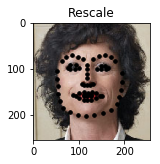

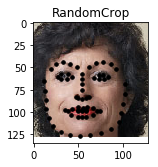

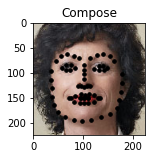

In [12]:
# Compose Transforms
# Now apply transforms on sample.
# we want to rescale the shorter side of the image to 256 and then randomly crop a square of size 224 from it.
# i.e. we want to compose Rescale and RandomCrop transforms. torchvision.transforms.Compose is a simple callable class which allows us to do this.

scale = Rescale(256)
crop = RandomCrop(128)    # we cannot apply 224 as output_size here beacause the shape of image is (160, 160, 3) so first we need to rescale it in order to apply.
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
print(sample['image'].shape)
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)
plt.show()

(828, 630, 3)


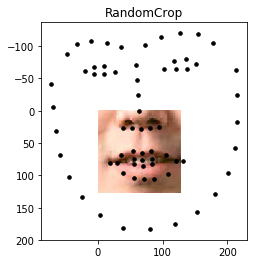

In [13]:
# In Random Crop, we have changed the origin of landmarks but we are still considering those landmarks which lie out of the cropped area.
plt.figure()
sample = face_dataset[4]
print(sample['image'].shape)
transformed_sample = crop(sample)
plt.title(type(crop).__name__)
show_landmarks(**transformed_sample)
plt.show()

In [14]:
# Iterating through the dataset
# create a dataset with composed transforms.
# Every time this dataset is sampled:
    # An image is read from the file on the fly
    # Transforms are applied on the read image
    # since one of the transforms is random, data is augmented on sampling

transformed_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                          root_dir='faces/',
                                          transform=transforms.Compose([
                                              Rescale(256),
                                              RandomCrop(224),
                                              ToTensor()
                                          ]))
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['landmarks'].size())
    
    if i==3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


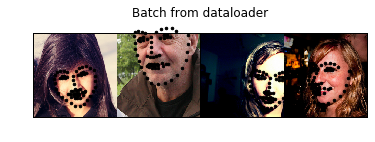

In [15]:
# we are losing a lot of features by using a simple for loop to iterate over the data. In particular we are missing out on:
    # Batching the data
    # Shuffling the data
    # Load the data in parallel using multiprocessing workers(num_workers parameter).
# torch.utils.data.DataLoader is an iterator which provides all these features.
# One parameter of interest is collate_fn which allows us to specify how exactly the samples need to be batched. Default collate works fine for most of use cases.

dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True)

# helper function to show a batch

def show_landmarks_batch(sample_batch):
    # show images with landmarks for a batch of samples
    
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose(1, 2, 0))
    
    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i*im_size, landmarks_batch[i, :, 1].numpy(), s=25, marker='.', c='k')
        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(), sample_batched['landmarks'].size())
    
    # observe the 4th batch and and stop
    if i_batch==3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff
        plt.show()
        break

In [16]:
# Afterword : Torchvision
# we have seen how to write and use datasets, transforms, and dataloader.
# torchvision package provides some common datasets and transforms. You may not even have to write custom classes.

In [17]:
# One of the more genric datasets is 'ImageFolder'. It assumes that images are orgaminzed in following way:
    #root/ants/xxx.png
    #root/ants/xxy.jpeg
    #root/ants/xxz.png
    #.
    #.
    #.
    #root/bees/123.jpg
    #root/bees/nsdf3.png
    #root/bees/asd932_.png
# where ‘ants’, ‘bees’ etc. are class labels

In [18]:
#  Similarly generic transforms which operate on PIL.Image like RandomHorizontalFlip, Scale, are also available. You can use these to write a dataloader like this:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)